In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-02 15:55:54--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.05s   

2020-04-02 15:55:55 (1.31 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



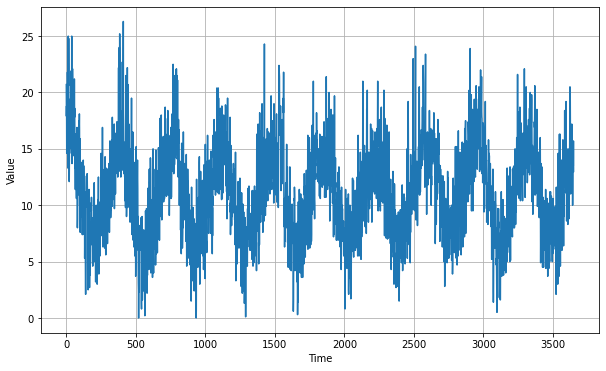

In [8]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  # print (next(reader))
  for count,row in enumerate(reader):
    time_step.append(count)
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                         strides=1, padding='causal',
                         activation='relu',
                         input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 36ms/step - loss: 40.2873 - mae: 40.7967 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 41ms/step - loss: 38.9961 - mae: 39.5424 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 43ms/step - loss: 37.0851 - mae: 37.6270 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 34.7809 - mae: 35.3280 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 43ms/step - loss: 32.1965 - mae: 32.7537 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 41ms/step - loss: 29.3768 - mae: 29.9478 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 44ms/step - loss: 26.3686 - mae: 26.9385 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 40ms/step - loss: 23.1515 - mae: 23.7307 - l

(1e-08, 0.0001, 0.0, 60.0)

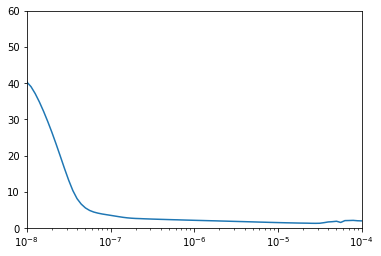

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [68]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                         strides=1, padding='causal',
                         activation='relu',
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 0s 20ms/step - loss: 9.8211 - mae: 10.4694
Epoch 2/150
25/25 [==============================] - 1s 21ms/step - loss: 2.5191 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 1s 21ms/step - loss: 1.9513 - mae: 2.4047
Epoch 4/150
25/25 [==============================] - 1s 22ms/step - loss: 1.8610 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 1s 22ms/step - loss: 1.8209 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 1s 22ms/step - loss: 1.7906 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 1s 22ms/step - loss: 1.7667 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 1s 23ms/step - loss: 1.7387 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 1s 23ms/step - loss: 1.7173 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 1s 21ms/step - loss: 1.6987 - mae: 2.1482
Epoch 11/150
25/25 [============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

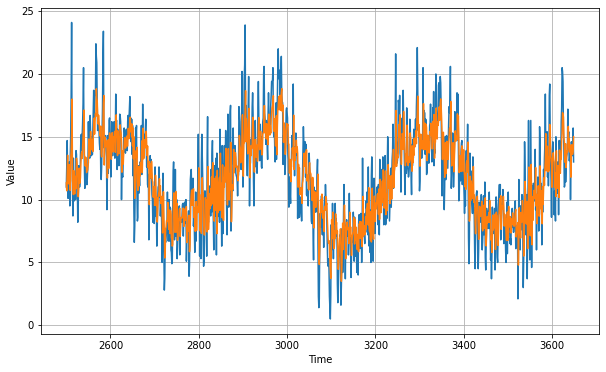

In [70]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [71]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7796336

In [72]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.329381 10.70565  12.124994 ... 13.604201 13.796568 15.009139]
